In [1]:
import math

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import gpytorch
import torch

import pyro
from pyro.infer.mcmc import NUTS, MCMC
pyro.set_rng_seed(0)

Let's make a small dataset.

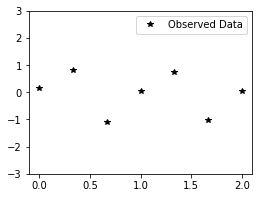

In [2]:
train_x = torch.linspace(0, 2, 7)
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.1

f, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
ax.set_ylim([-3, 3])
ax.legend(['Observed Data']);

And create a GPyTorch model.

In [3]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, batch_shape=torch.Size()):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(
            batch_shape=batch_shape,
        )
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(batch_shape=batch_shape),
            batch_shape=batch_shape
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood, batch_shape=torch.Size())
model.train()
likelihood.train()
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

Create initial parameters for NUTS. Currently, these raw parameters are initialized by `0`.

In [4]:
init_params = {k: v for k, v in model.state_dict().items()}
init_params

{'likelihood.noise_covar.raw_noise': tensor([0.]),
 'mean_module.constant': tensor([0.]),
 'covar_module.raw_outputscale': tensor(0.),
 'covar_module.base_kernel.raw_lengthscale': tensor([[0.]]),
 'covar_module.base_kernel.raw_period_length': tensor([[0.]])}

Now, we put uniform priors on the hyperparameters.

In [5]:
model.likelihood.noise_covar.register_constraint('raw_noise', gpytorch.constraints.Interval(0., 0.01))
model.covar_module.register_constraint('raw_outputscale', gpytorch.constraints.Interval(0., 10.))
model.covar_module.base_kernel.register_constraint('raw_lengthscale', gpytorch.constraints.Interval(0., 10.))
model.covar_module.base_kernel.register_constraint('raw_period_length', gpytorch.constraints.Interval(0., 10.))

Because NUTS runs in unconstrained space, we need to adjust log density by jacobian of transforms. The following utility computes the jacobian of `model`'s transforms.

In [6]:
def transform_jacobian(model, params):
    r = 0
    for name, param in params.items():
        constraint = model.constraint_for_parameter_name(name)
        if isinstance(constraint, gpytorch.constraints.GreaterThan):
            # derivative of softplus is sigmoid
            r = r + torch.sigmoid(param).sum()
        elif isinstance(constraint, gpytorch.constraints.Interval):
            # derivative of sigmoid and affine transform
            sigmoid = torch.sigmoid(param)
            jac = torch.log(sigmoid * (1 - sigmoid) * (constraint.upper_bound - constraint.lower_bound))
            r = r + jac.sum()
    return r

Let's make a potential energy function from `mll` and run NUTS with that potential function.

In [7]:
def potential_fn(params):
    try:
        model._load_raw_parameters(**params)
        output = model(train_x)
        log_joint = mll(output, train_y).sum()
        log_joint = log_joint + transform_jacobian(model, params)
        return -log_joint
    except:  # return `nan` instead of raise Value Error if not be able to get Cholesky
        r = 0
        for p in params.values():
            r = r + 0 * p.sum()
        return torch.tensor(float('nan')) + r

hmc_kernel = NUTS(model=None, potential_fn=potential_fn)
hmc_kernel.initial_params = init_params
mcmc_run = MCMC(hmc_kernel, num_samples=100, warmup_steps=100).run()

Sample: 100%|██████████| 200/200 [02:28<00:00, 15.09it/s, step size=3.36e-01, acc. rate=0.985]


Because Pyro's NUTS works in unconstrained space (the space of raw parameters), we need to transform it back to the constrained space.

In [8]:
def inv_transform(model, params):
    samples = {}
    for name, param in params.items():
        constraint = model.constraint_for_parameter_name(name)
        if constraint is not None:
            splitted_name = name.split('.')
            new_name = '.'.join(splitted_name[:-1] + [splitted_name[-1].lstrip('raw_')])
            samples[new_name] = constraint.transform(param)
        else:
            samples[name] = param
    return samples

Now, we'll collect samples and plot the posteriors.

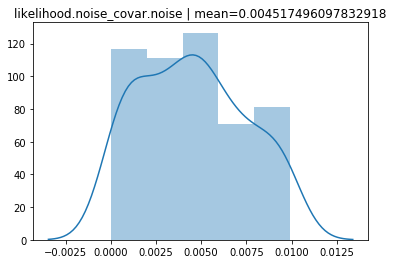

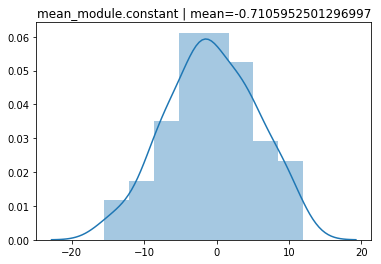

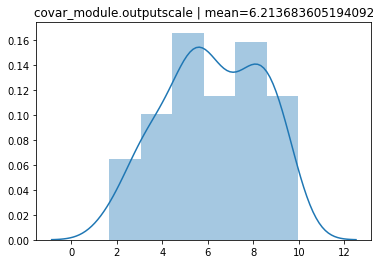

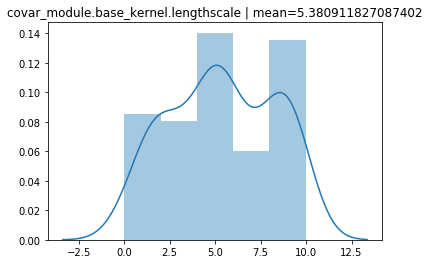

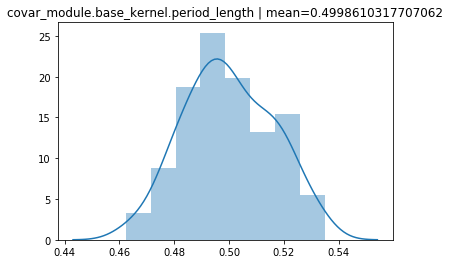

In [9]:
samples = [inv_transform(model, params) for params in mcmc_run.exec_traces]
merged_samples = {}
for name in samples[0]:
    merged_samples[name] = torch.stack([sample[name] for sample in samples])

for name in merged_samples:
    sns.distplot(merged_samples[name])
    plt.title(name + " | mean={}".format(merged_samples[name].mean().item()))
    plt.show()